# How do the extended source fringes compare to the changing fringe transmission on the sides of the point source PSF peak?
In notebook 5 we examined how the fringe transmission of a point source changes at different locations on the PSF. Where do the extended source fringes stand with respect to this change in transmission? In Notebook 1 - Test 3 the extended source fringes were shown not to move. Let's look at that again.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
ext_etal_source_sci,ext_etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
lambdaMap[lambdaMap==0] = np.nan
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

We subtract background exposures where available.

In [3]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
ext_etal_source_bkgsubtr = ext_etal_source_sci-ext_etal_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [4]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
ext_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

Much like in Notebook 5 - Test 1 we take the three slices that contain the PSF (slices with largest signal), determine the pixel trace that contains the peak of the PSF, and then take the two traces on the left and the right to probe the sides of the PSF. The same positions are used to evaluate the extended source fringes.

In [5]:
# Pixel trace in MRS slice
ypos_sourcecenterslice,xpos_sourcecenterslice = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=0)
ypos_nearbyslice1,xpos_nearbyslice1 = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=-1)
ypos_nearbyslice2,xpos_nearbyslice2 = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=1)
xpos_offsets = [-2,-1,0,1,2]

### Test 1: Compare extended source and point source fringes in along-slice direction  
Note that the etalon and point source plots are the same as in Notebook 5. We introduce two new plots, one for the fringe analysis of the extended source, and one where the extended and point source fringe transmissions are compared.

In [6]:
# normalize signal
pointsource_slice6_norm,pointsource_slice7_norm,pointsource_slice8_norm = [{} for i in range(3)]
for xpos_offset in xpos_offsets:
    pointsource_slice6_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],thres=0,min_dist=6,k=1,ext=3)
    pointsource_slice7_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],thres=0,min_dist=6,k=1,ext=3)
    pointsource_slice8_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],thres=0,min_dist=6,k=1,ext=3)
    
extsource_slice6_norm,extsource_slice7_norm,extsource_slice8_norm = [{} for i in range(3)]
for xpos_offset in xpos_offsets:
    extsource_slice6_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(ext_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],thres=0,min_dist=6,k=3,ext=3)
    extsource_slice7_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(ext_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],thres=0,min_dist=6,k=3,ext=3)
    extsource_slice8_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(ext_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],thres=0,min_dist=6,k=3,ext=3)

# average of extended source normalized signals
extsource_slice6_norm_avg,extsource_slice7_norm_avg,extsource_slice8_norm_avg = np.zeros(3)
for xpos_offset in xpos_offsets:
    extsource_slice6_norm_avg += extsource_slice6_norm['offset'+str(xpos_offset)][0]/extsource_slice6_norm['offset'+str(xpos_offset)][2]
    extsource_slice7_norm_avg += extsource_slice7_norm['offset'+str(xpos_offset)][0]/extsource_slice7_norm['offset'+str(xpos_offset)][2]
    extsource_slice8_norm_avg += extsource_slice8_norm['offset'+str(xpos_offset)][0]/extsource_slice8_norm['offset'+str(xpos_offset)][2]
extsource_slice6_norm_avg /= len(xpos_offsets)
extsource_slice7_norm_avg /= len(xpos_offsets)
extsource_slice8_norm_avg /= len(xpos_offsets)

<IPython.core.display.Javascript object>


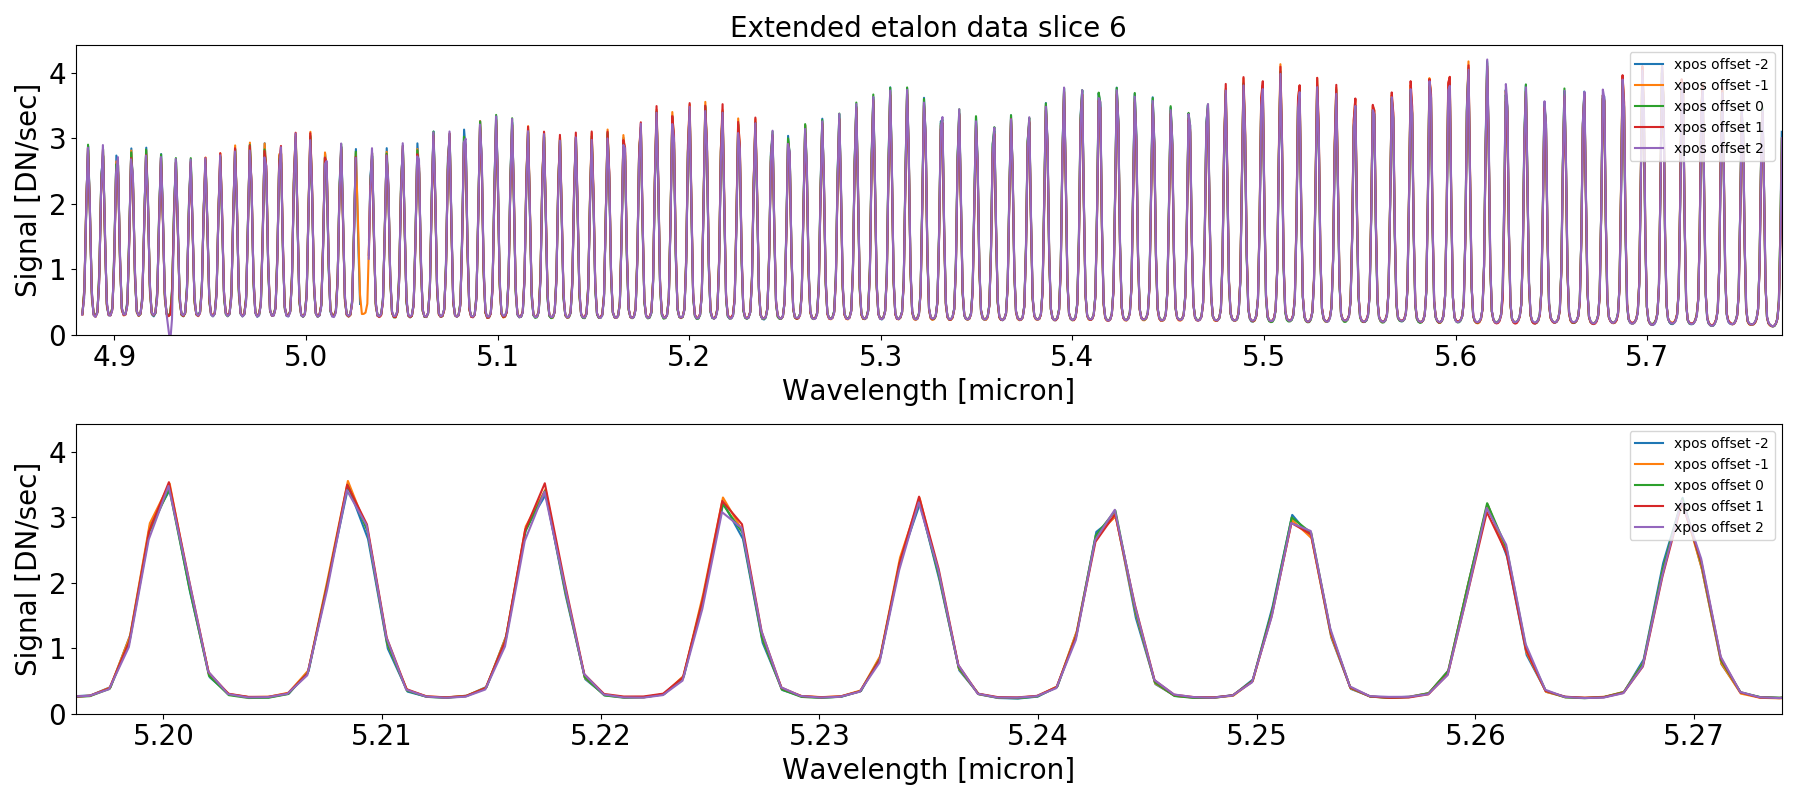

<IPython.core.display.Javascript object>


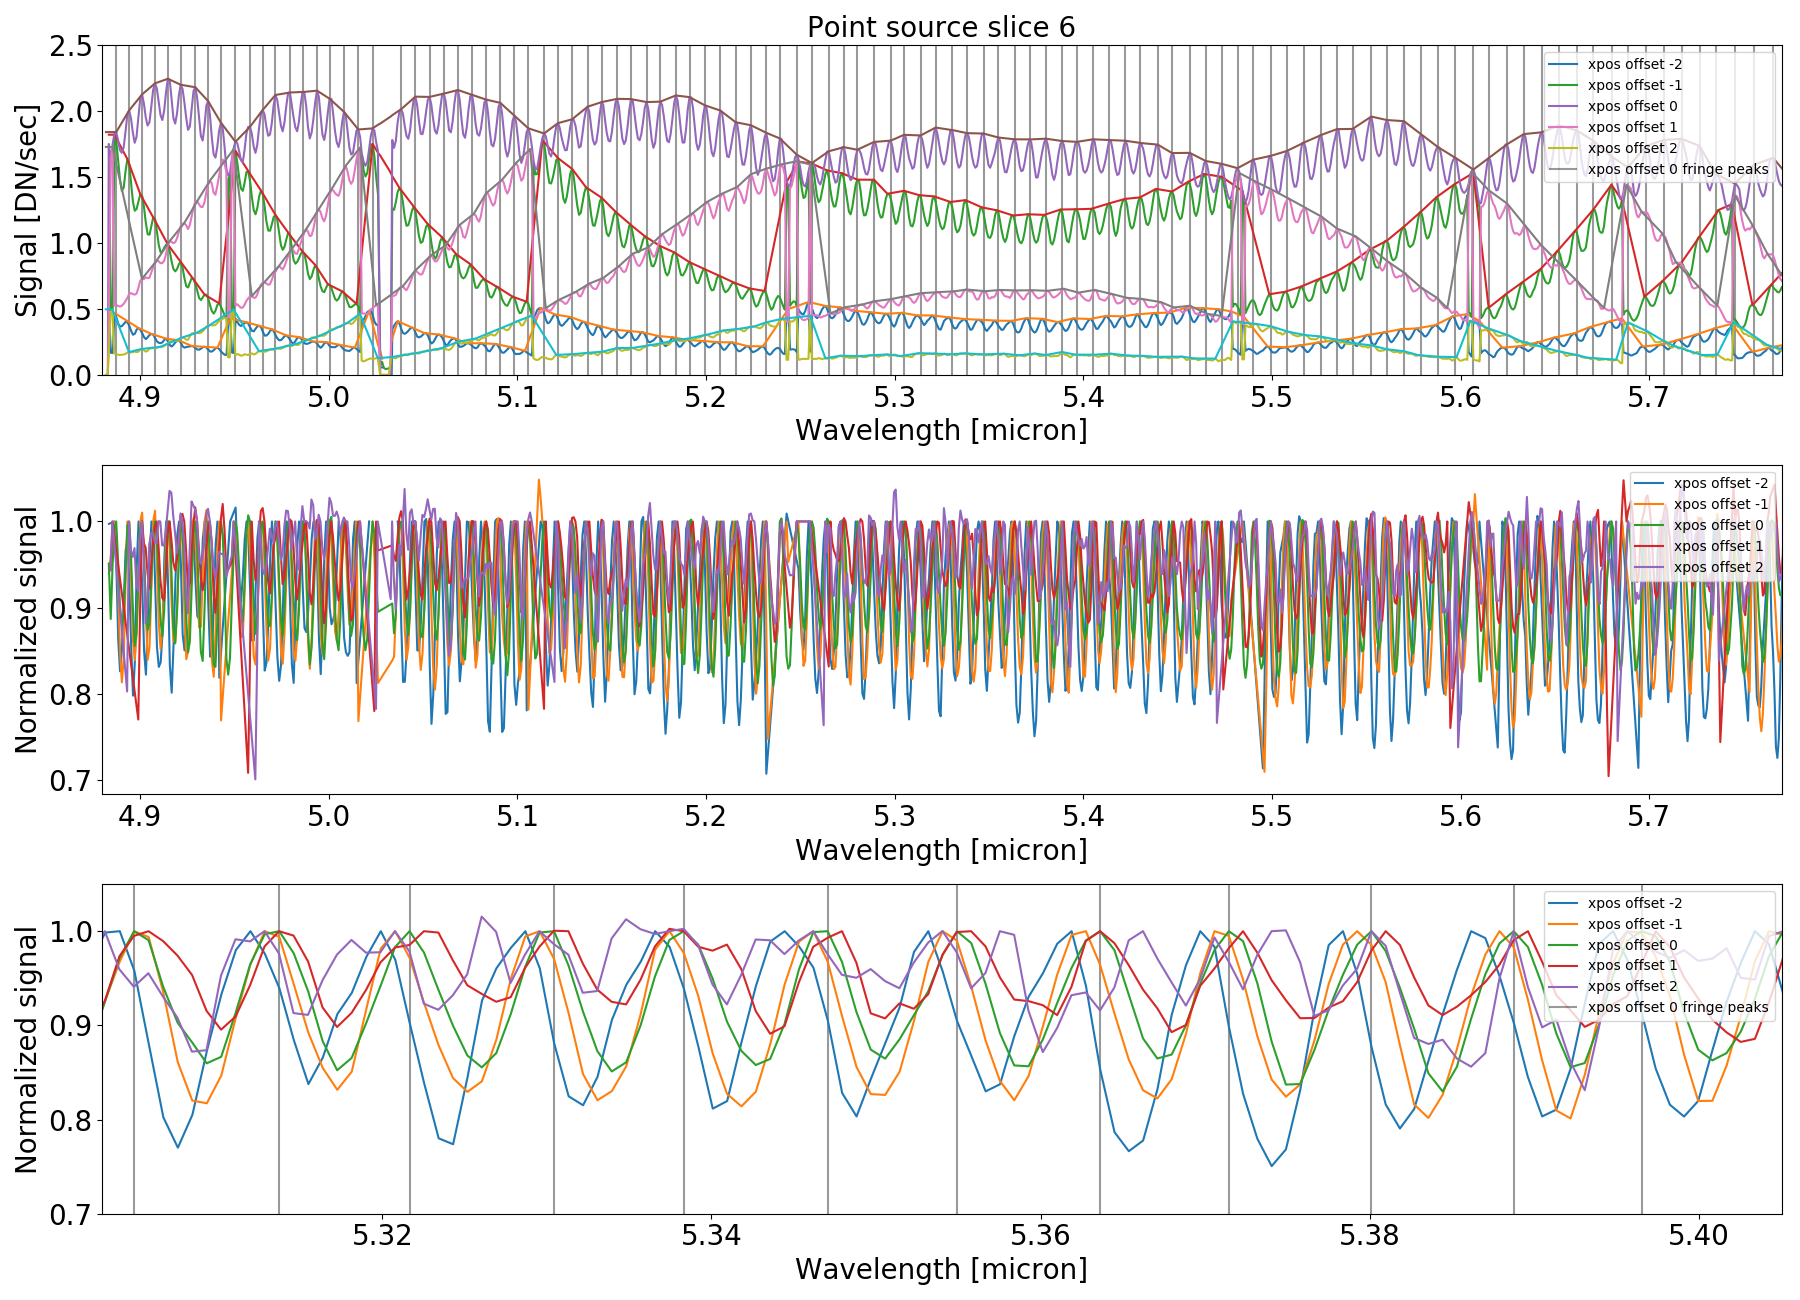

<IPython.core.display.Javascript object>


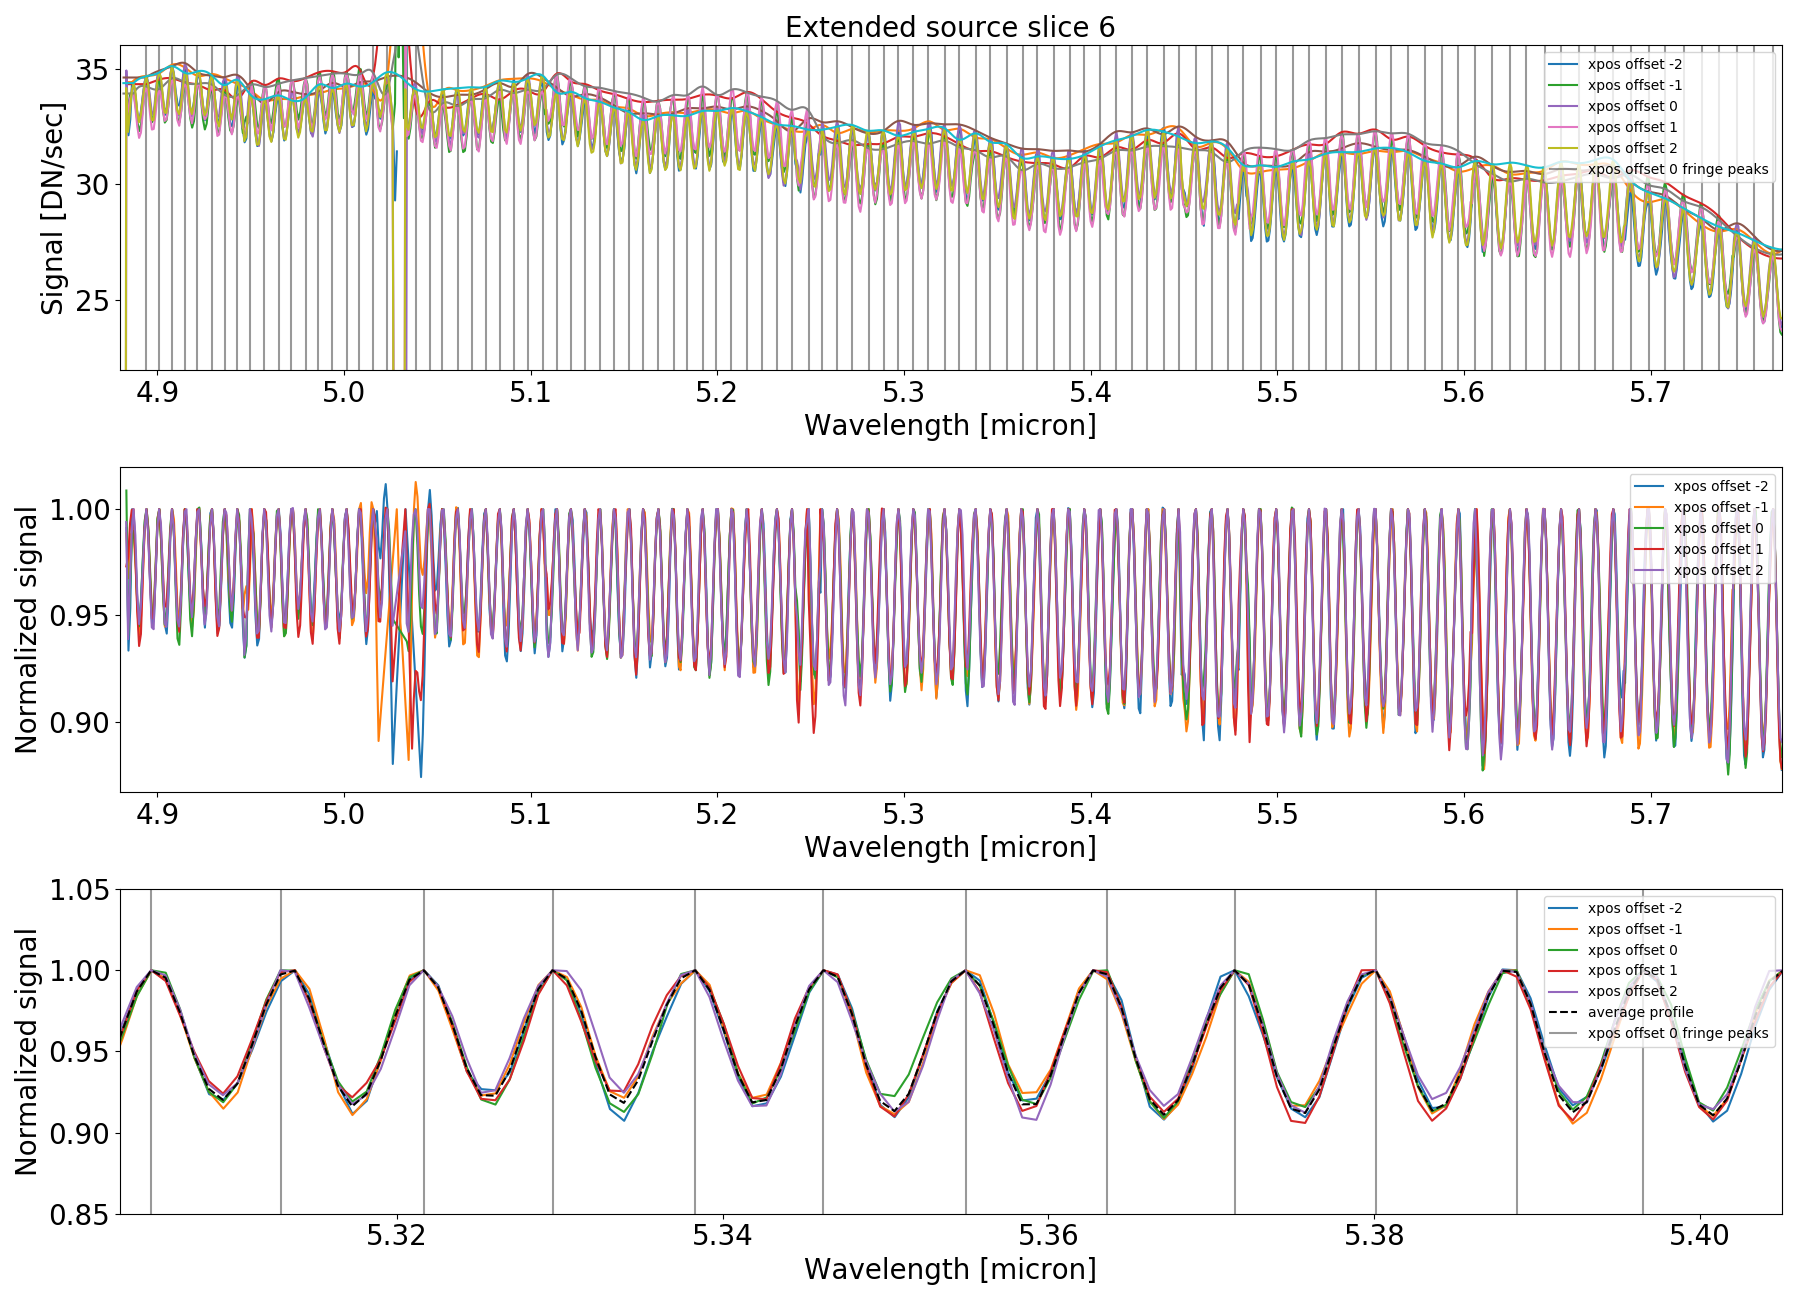

In [7]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Extended etalon data slice 6')
for xpos_offset in xpos_offsets:
    for plot in range(2):
        axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],label='xpos offset {}'.format(xpos_offset))
        axs[plot].set_xlabel('Wavelength [micron]')
        axs[plot].set_ylabel('Signal [DN/sec]')
        axs[plot].legend(loc='upper right',fontsize=10)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0)
axs[1].set_xlim(5.196,5.274)
axs[1].set_ylim(0)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Point source slice 6')
axs[0].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][pointsource_slice6_norm['offset0'][1]],0,2.5,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],pointsource_slice6_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],pointsource_slice6_norm['offset'+str(xpos_offset)][2])
    norm_transmission = pointsource_slice6_norm['offset'+str(xpos_offset)][0]/pointsource_slice6_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][pointsource_slice6_norm['offset0'][1]],0.7,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(0,2.5)
axs[2].set_xlim(5.303,5.405)
axs[2].set_ylim(0.7,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Extended source slice 6')
axs[0].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][extsource_slice6_norm['offset0'][1]],22,36,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],extsource_slice6_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],extsource_slice6_norm['offset'+str(xpos_offset)][2])
    norm_transmission = extsource_slice6_norm['offset'+str(xpos_offset)][0]/extsource_slice6_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.87) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],extsource_slice6_norm_avg[sel],'k',linestyle='dashed',label='average profile')
axs[2].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][extsource_slice6_norm['offset0'][1]],0.85,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(22,36)
axs[2].set_xlim(5.303,5.405)
axs[2].set_ylim(0.85,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

<IPython.core.display.Javascript object>


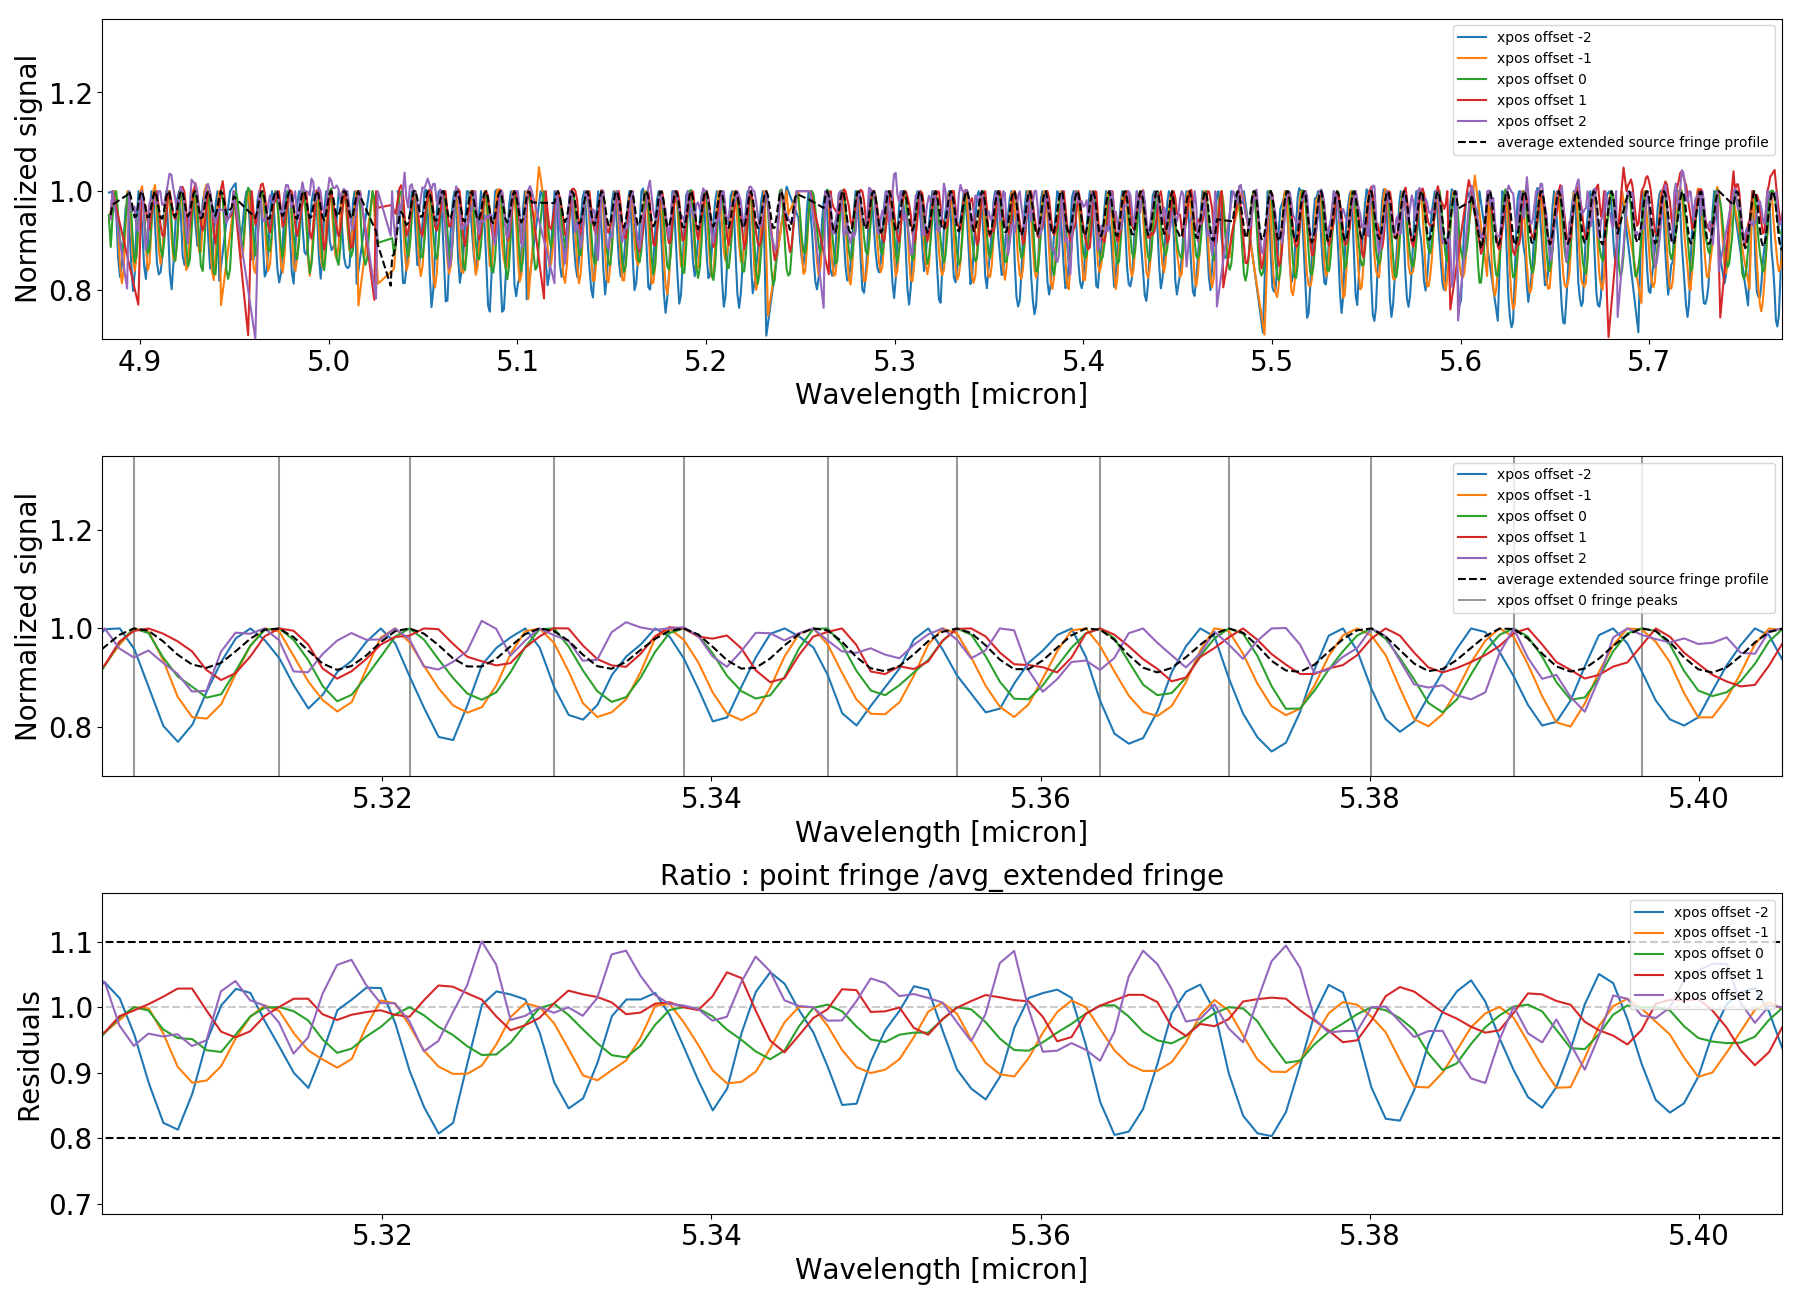

In [8]:
# let's look at the results
fig,axs = plt.subplots(3,1,figsize=(18,13))
for xpos_offset in xpos_offsets:
    norm_transmission = pointsource_slice6_norm['offset'+str(xpos_offset)][0]/pointsource_slice6_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[1].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel]/extsource_slice6_norm_avg[sel],label='xpos offset {}'.format(xpos_offset))
axs[1].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][pointsource_slice6_norm['offset0'][1]],0.7,1.35,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[2].hlines([0.8,1.1],4.88,5.77,linestyle='dashed')
axs[2].hlines(1,4.88,5.77,'gray',alpha=0.4,linestyle='dashed')
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.303,5.405)
axs[2].set_xlim(5.303,5.405)
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],extsource_slice6_norm_avg[sel],'k',linestyle='dashed',label='average extended source fringe profile')
    axs[plot].set_ylim(0.7,1.35)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=10)
axs[2].set_xlabel('Wavelength [micron]')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Ratio : point fringe /avg_extended fringe')
axs[2].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* As illustrated in Notebook 1 - Test 3, the extended source fringe profile does not change in phase in different along-slice positions. Given that the contrast of the fringes also stays relatively even, we take an average fringe profile to compare to the point source fringes. 
* As shown in Notebook 5 - Test 2, the phase and amplitude of the point source fringes changes as a function of location on the (spatial) PSF. We use extended etalon data to ensure that we do not move spectrally [is this enough? ==>] We also used point source etalon data in Notebook 3 - Test 2 to check whether etalon lines move in wavelength as a function of location on the PSF, and they don't.
* What the comparative figure between the point source fringes and the (average) extended source fringe profile implies is that any conceivable fringe correction that works perfectly for an extended source **cannot** work for a point source. 
* In the example shown above (slice 6), using the extended source fringe profile as "the fringe correction" (i.e. dividing by it yields a normalized extended source fringe signal of 1), yields a peak-to-peak fringe residual of: 
    * 23% for the fringes in xpos offset -2
    * 12% at xpos offset -1
    * 7%  at xpos offset +0 (PSF peak)
    * 6%  at xpos offset +1
    * 15% at xpos offset +2
    * Bear in mind that these values apply to the **fringe** residuals, not the signal value [DN/sec] extracted from the point source (e.g. xpos offset -2 has a smaller relative signal compared to xpos offset +0).
* Although a discrepancy in fringe contrast can be claimed to be due to an angle-averaging effect (e.g. MRS resolution, MTS cone angle, loss of phase information in detector active layer, other), it is difficult to reconcile the different fringe peak positions.
  
Let's quickly look at the other slices (refer to Notebook 5 for the omitted etalon and point source plots).

<IPython.core.display.Javascript object>


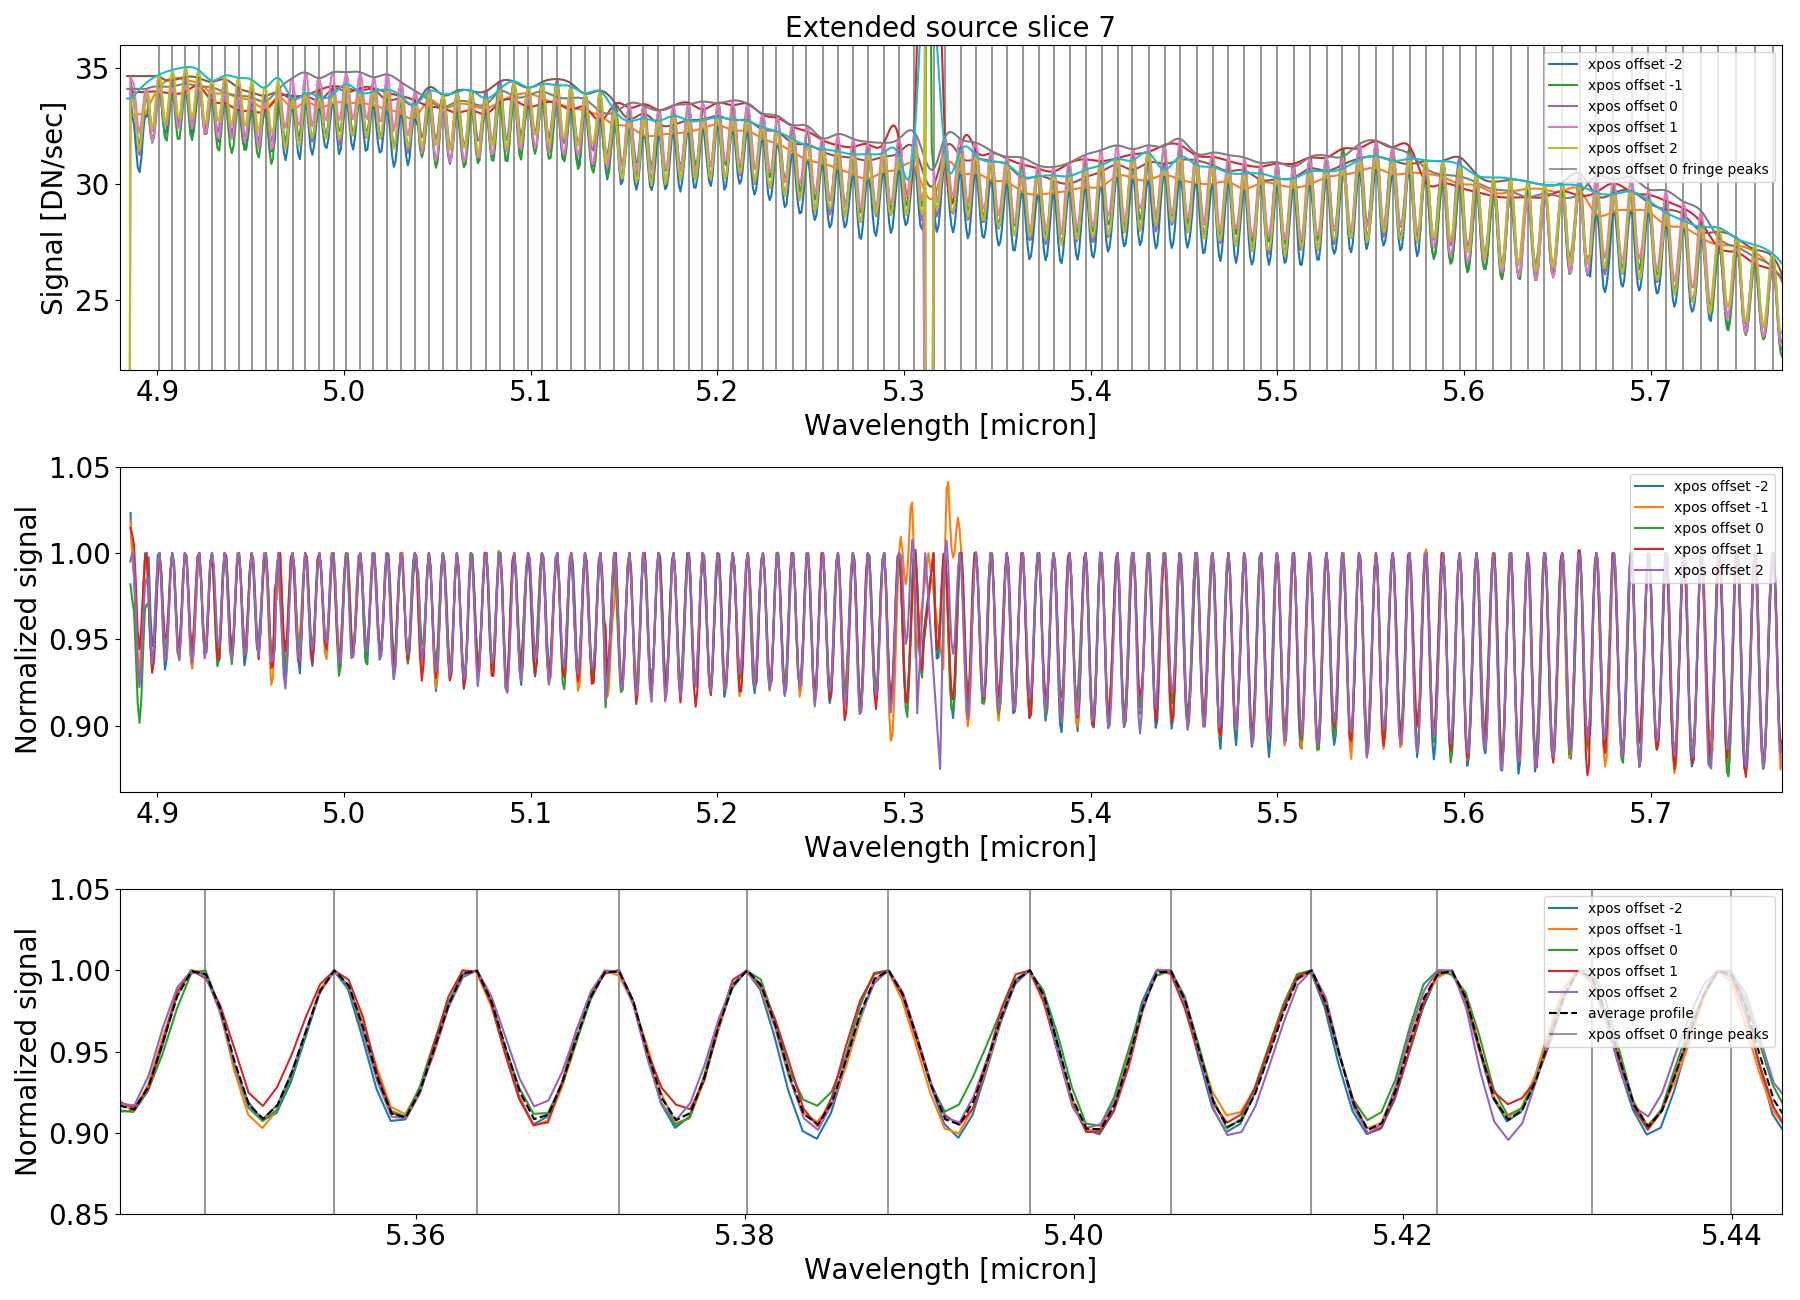

<IPython.core.display.Javascript object>


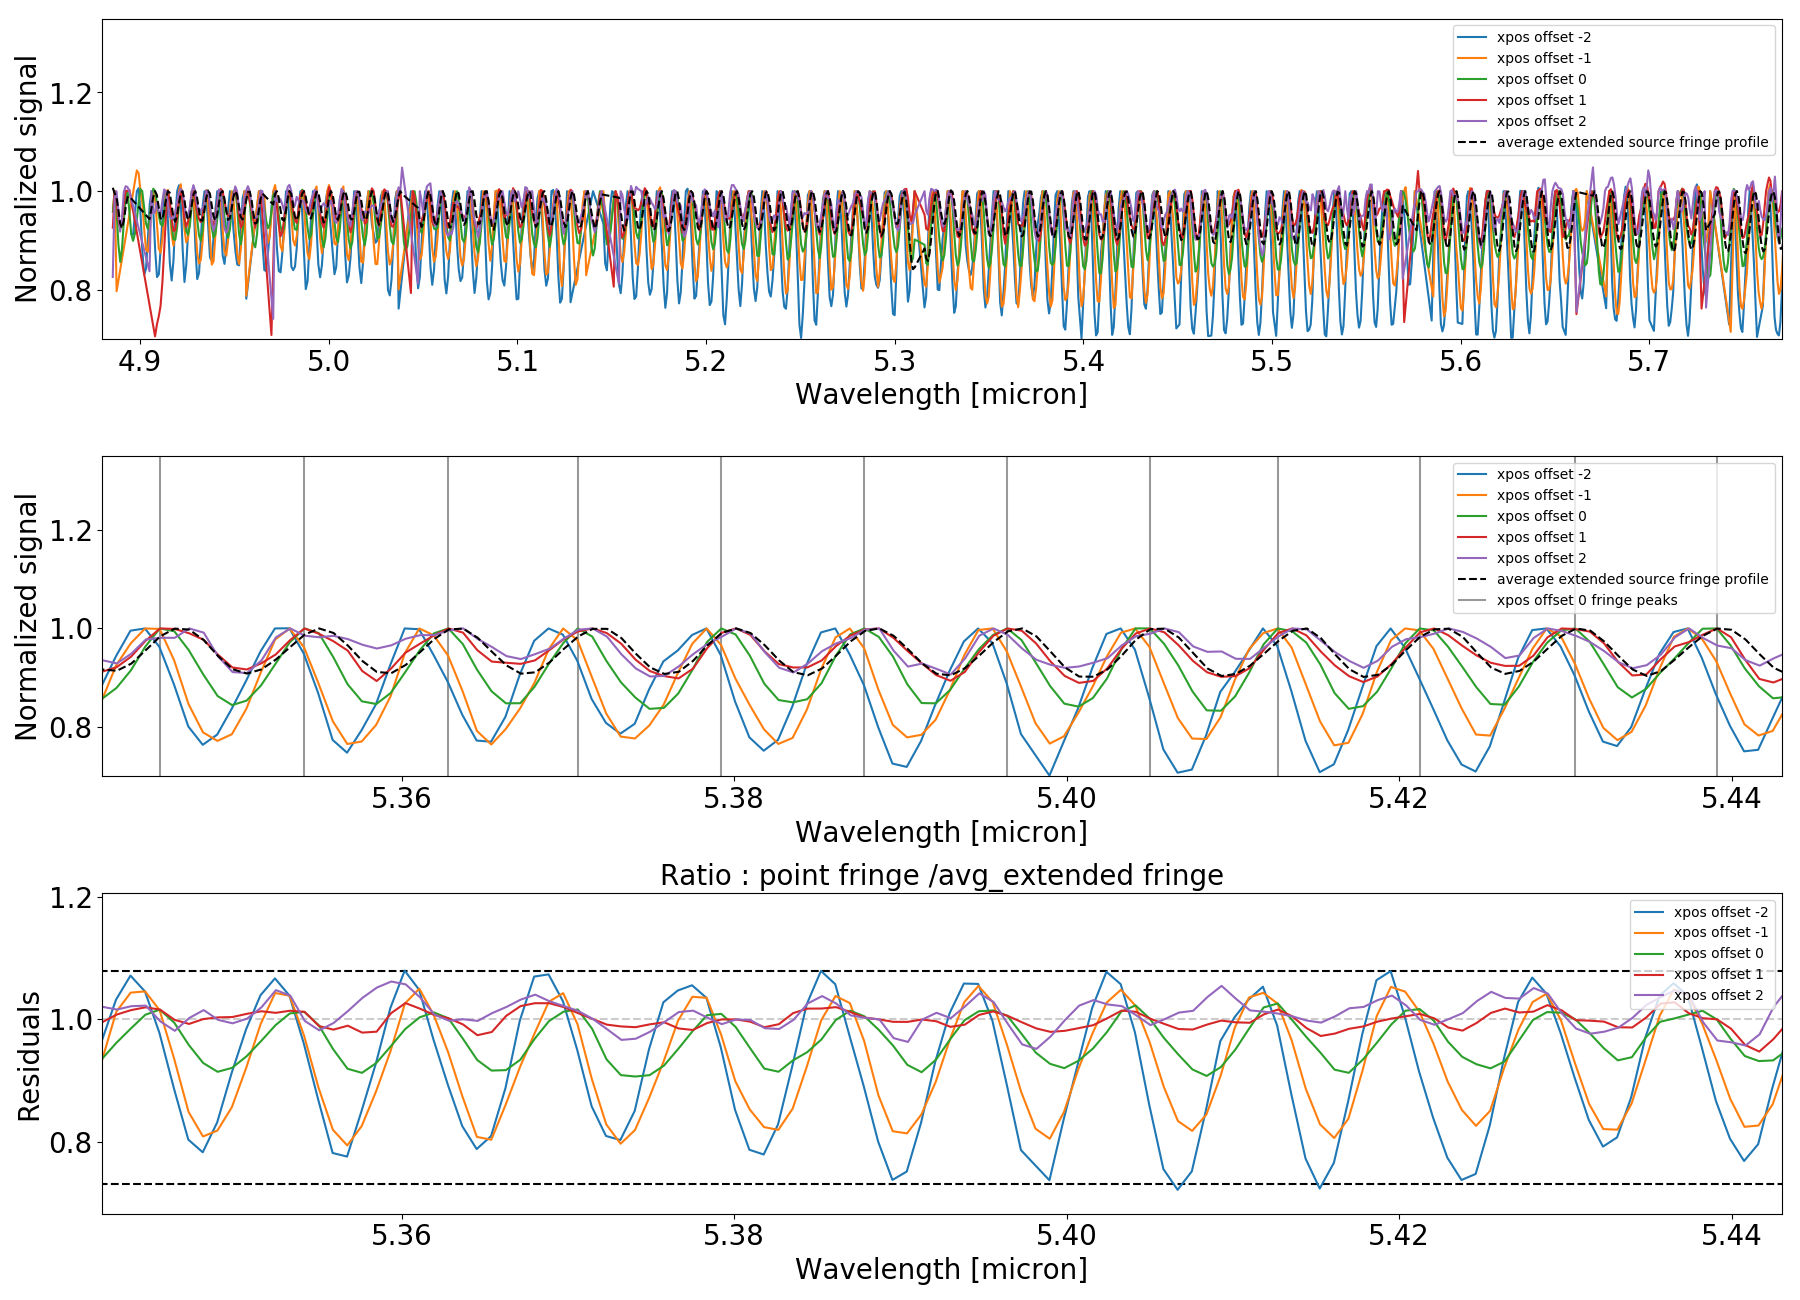

In [9]:
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Extended source slice 7')
axs[0].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][extsource_slice7_norm['offset0'][1]],22,36,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],extsource_slice7_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],extsource_slice7_norm['offset'+str(xpos_offset)][2])
    norm_transmission = extsource_slice7_norm['offset'+str(xpos_offset)][0]/extsource_slice7_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.87) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],extsource_slice7_norm_avg[sel],'k',linestyle='dashed',label='average profile')
axs[2].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][extsource_slice7_norm['offset0'][1]],0.85,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(22,36)
axs[2].set_xlim(5.342,5.443)
axs[2].set_ylim(0.85,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
for xpos_offset in xpos_offsets:
    norm_transmission = pointsource_slice7_norm['offset'+str(xpos_offset)][0]/pointsource_slice7_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[1].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel]/extsource_slice7_norm_avg[sel],label='xpos offset {}'.format(xpos_offset))
axs[1].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][pointsource_slice7_norm['offset0'][1]],0.7,1.35,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[2].hlines([0.73,1.08],4.88,5.77,linestyle='dashed')
axs[2].hlines(1,4.88,5.77,'gray',alpha=0.4,linestyle='dashed')
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.342,5.443)
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],extsource_slice7_norm_avg[sel],'k',linestyle='dashed',label='average extended source fringe profile')
    axs[plot].set_ylim(0.7,1.35)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=10)
axs[2].set_xlim(5.342,5.443)
axs[2].set_xlabel('Wavelength [micron]')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Ratio : point fringe /avg_extended fringe')
axs[2].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* There seems to be agreement between the average extended source fringe profile and the point source fringe transmission at xpos offset +1.
* In slice 7 (center of PSF), using the extended source fringe profile as the fringe correction, yields a peak-to-peak fringe residual of: 
    * 30% for the fringes in xpos offset -2
    * 23% at xpos offset -1
    * 11%  at xpos offset +0 (PSF peak)
    * 4%  at xpos offset +1
    * 7% at xpos offset +2
  
Let's look at the last slice.

<IPython.core.display.Javascript object>


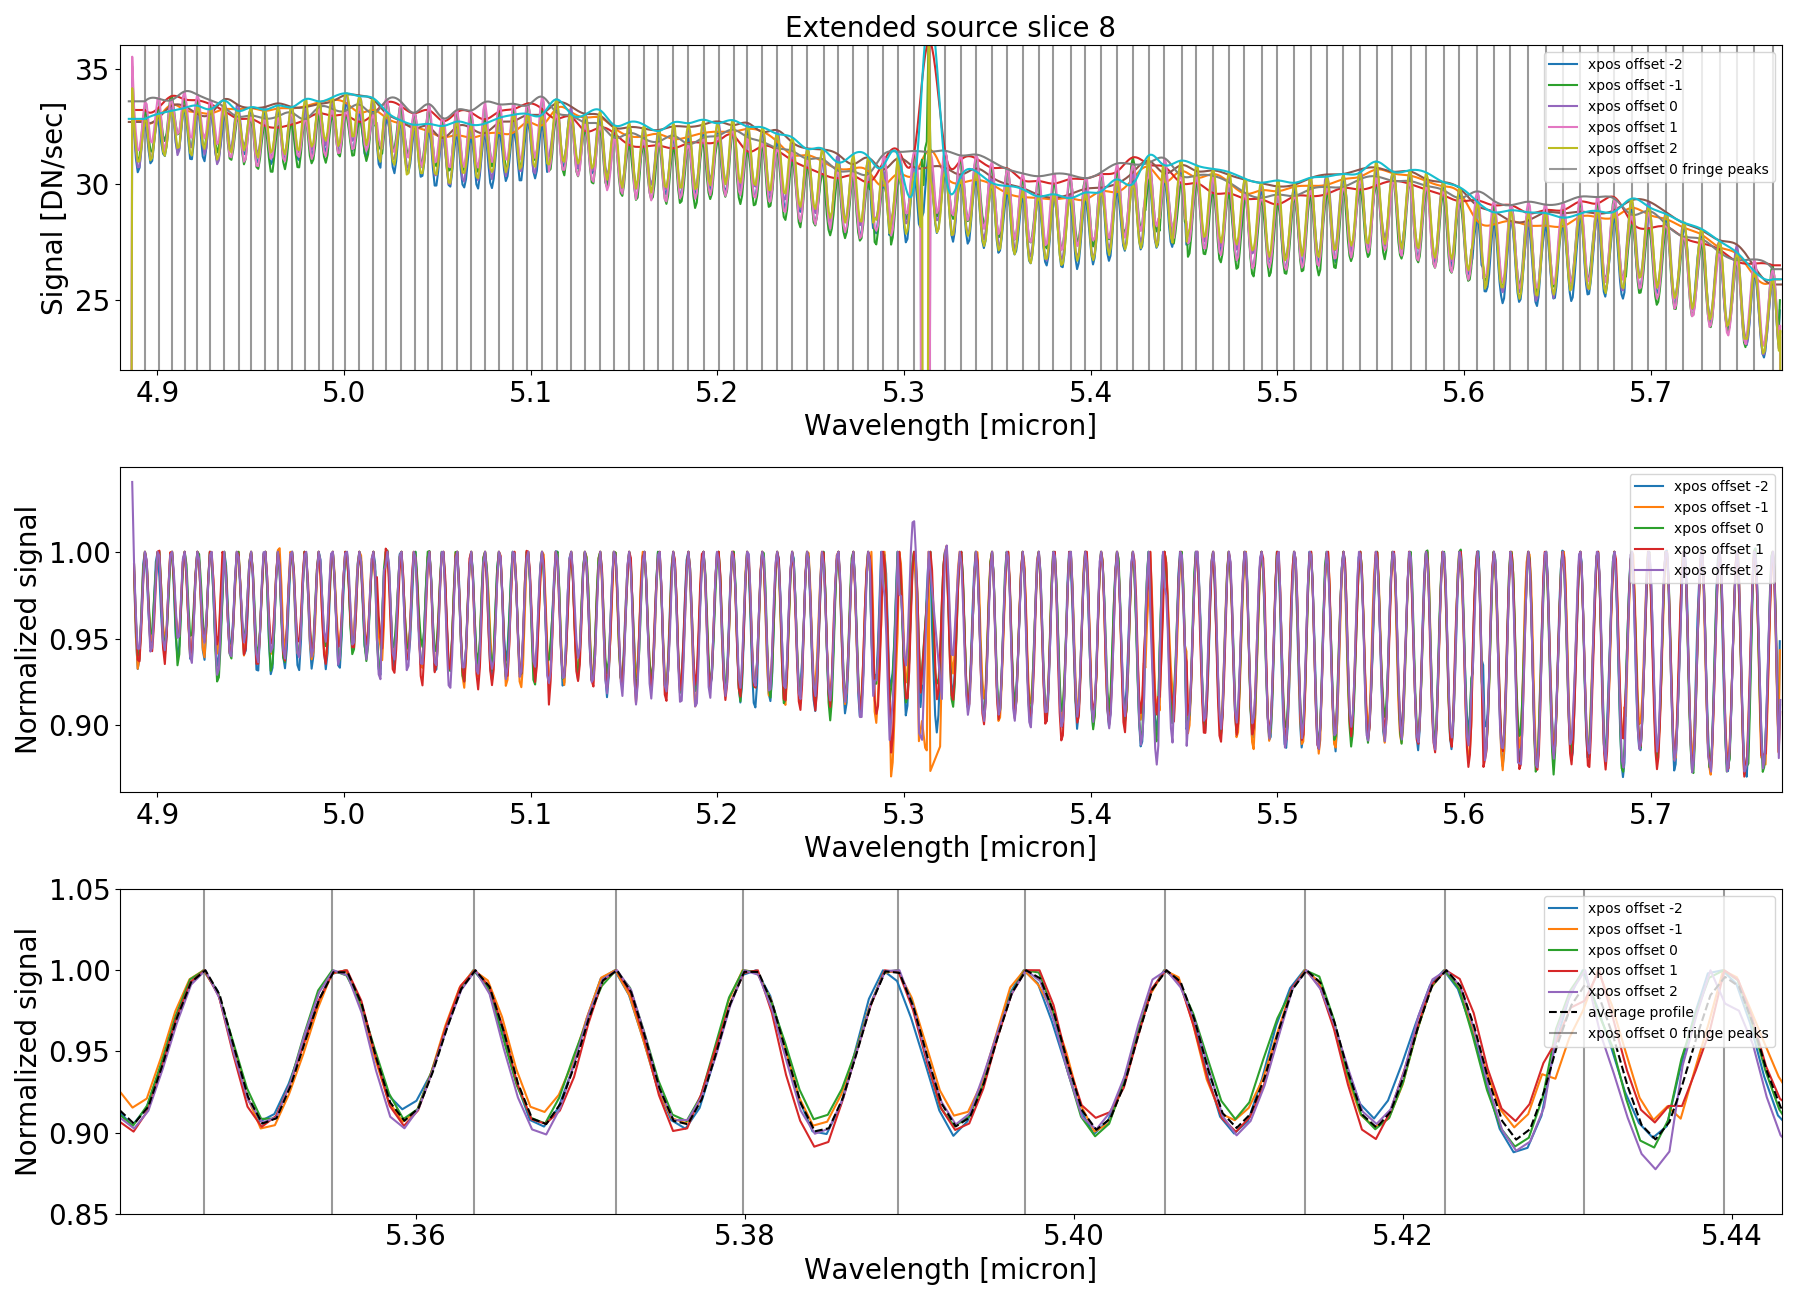

<IPython.core.display.Javascript object>


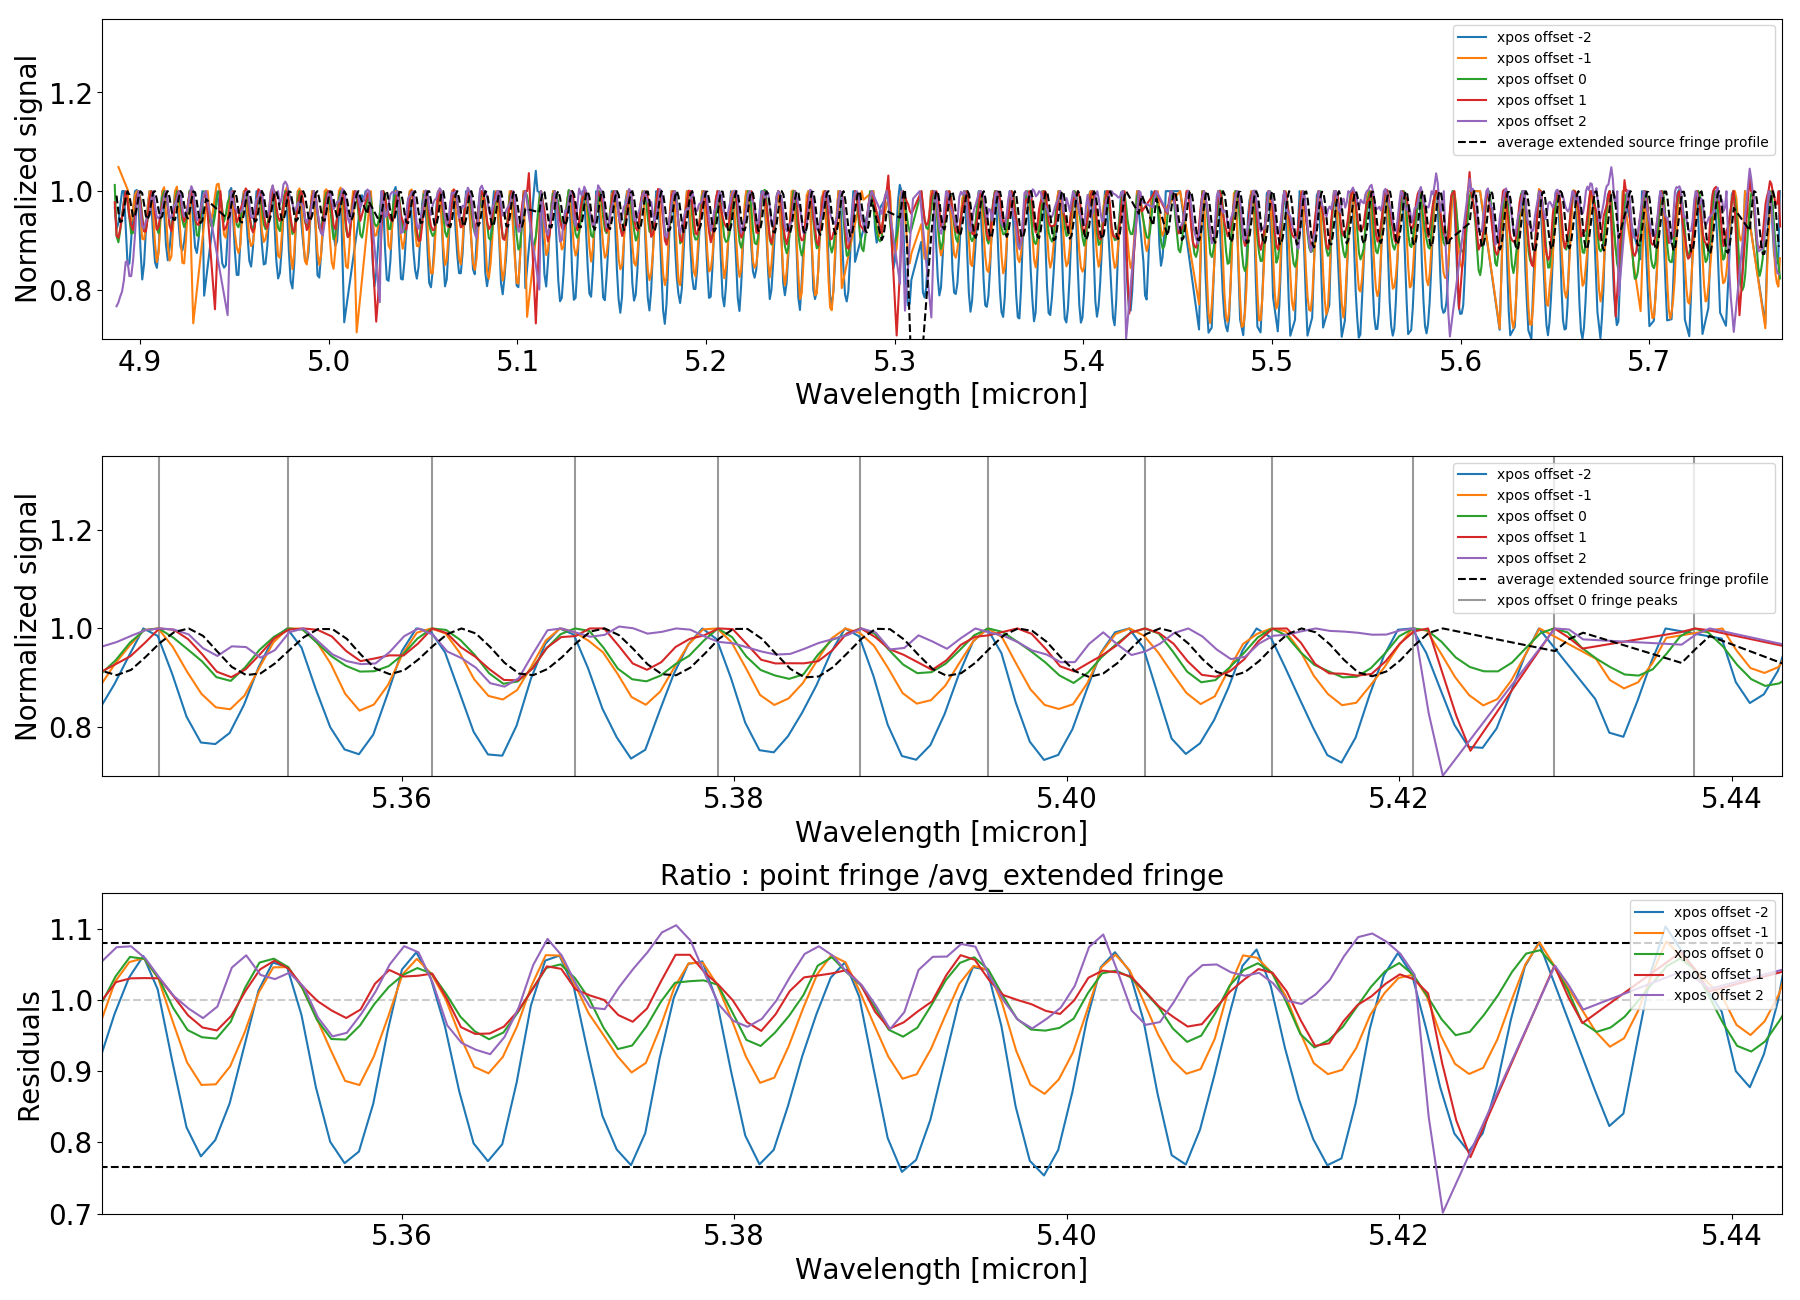

In [10]:
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Extended source slice 8')
axs[0].vlines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][extsource_slice8_norm['offset0'][1]],22,36,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],extsource_slice8_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],extsource_slice8_norm['offset'+str(xpos_offset)][2])
    norm_transmission = extsource_slice8_norm['offset'+str(xpos_offset)][0]/extsource_slice8_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.87) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],extsource_slice8_norm_avg[sel],'k',linestyle='dashed',label='average profile')
axs[2].vlines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][extsource_slice8_norm['offset0'][1]],0.85,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(22,36)
axs[2].set_xlim(5.342,5.443)
axs[2].set_ylim(0.85,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
for xpos_offset in xpos_offsets:
    norm_transmission = pointsource_slice8_norm['offset'+str(xpos_offset)][0]/pointsource_slice8_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[1].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel]/extsource_slice8_norm_avg[sel],label='xpos offset {}'.format(xpos_offset))
axs[1].vlines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][pointsource_slice8_norm['offset0'][1]],0.7,1.35,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[2].hlines([0.765,1.08],4.88,5.77,linestyle='dashed')
axs[2].hlines(1,4.88,5.77,'gray',alpha=0.4,linestyle='dashed')
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.342,5.443)
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],extsource_slice8_norm_avg[sel],'k',linestyle='dashed',label='average extended source fringe profile')
    axs[plot].set_ylim(0.7,1.35)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=10)
axs[2].set_xlim(5.342,5.443)
axs[2].set_ylim(0.7,1.15)
axs[2].set_xlabel('Wavelength [micron]')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Ratio : point fringe /avg_extended fringe')
axs[2].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* There seems to be better agreement between the point source fringe transmissions at the different along-slice positions (as illustrated by the overlapping residuals).
* In slice 8, using the extended source fringe profile as the fringe correction, yields a peak-to-peak fringe residual of: 
    * 38% for the fringes in xpos offset -2
    * 18% at xpos offset -1
    * 10%  at xpos offset +0 (PSF peak)
    * 8%  at xpos offset +1
    * 12% at xpos offset +2

## Conclusions:  
* The extended source fringe transmission does not change in along-slice direction.
* The position of the peaks in the extended source fringe transmission w.r.t. the point source fringes at xpos offset +0 (peak of PSF):
    * match in slice 6
    * are offset to the right (presumably not to the left) in slice 7 and slice 8
* Using the average extended source fringe profile as a fringe correction yields non-negligible point source fringe residuals due to the discrepancy in phase and ampltidue of the transmission.

## Follow-up question:  
How do we link the amplitude, frequency, and phase of the fringe transmissions, of the different optical stimuli, to (apparent) optical properties of the interfering resonator? Being able to do so would permit us to assess the possible causes for the transmission discrepancies.